# 1 Data cleaning<a id='1_Data_cleaning'></a>

## 1.1 Contents<a id='1.1_Contents'></a>
* [1 Data cleaning](#1_Data_cleaning)
  * [1.1 Contents](#1.1_Contents)
  * [1.2 Introduction](#1.2_Introduction)
    * [1.2.1 Recap Of Data Science Problem](#1.2.1_Recap_Of_Data_Science_Problem)
    * [1.2.2 Introduction To Notebook](#1.2.2_Introduction_To_Notebook)
  * [1.3 Objectives](#1.3_Objectives)
  * [1.4 Imports](#1.4_Imports)
  * [1.5 Load Data](#1.5_Load_Data)
    * [1.5.1 Meter Readings](#1.5.1_Meter_Readings)
    * [1.5.2 Building Characteristics](#1.5.2_Building_Characteristics)
    * [1.5.3 Weather Data](#1.5.3_Weather_Data)
    * [1.5.4 Number Of Missing Values](#1.5.4_Number_Of_Missing_Values)
  * [1.6 Exploration of the Data](#1.6_Exploration_of_the_Data)
    * [1.6.1 Categorical Features](#1.6.1_Categorical_Features)
      * [1.6.1.1 Building Primary Use](#1.6.1.1_Building_Primary_Use)
      * [1.6.1.2 Site ID](#1.6.1.2_Site_ID)
      * [1.6.1.3 Meters](#1.6.1.3_Meters)
    * [1.6.2 Numeric Features](#1.6.2_Numeric_Features)
      * [1.6.2.1 Numeric Data Summary](#1.6.2.1_Numeric_Data_Summary)
      * [1.6.2.2 Numeric Data Distribution](#1.6.2.2_Numeric_Data_Distribution)
    * [1.6.3 Identifying Potential Outliers](#1.6.3_Identifying_Potential_Outliers)
      * [1.6.3.1 Potential Outliers in meter_reading](#1.6.3.1_Potential_Outliers_in_meter_reading)
      * [1.6.3.2 Potential Outliers in precip_depth_1_hr](#1.6.3.2_Potential_Outliers_in_precip_depth_1_hr)

## 1.2 Introduction<a id='1.2_Introduction'></a>

### 1.2.1 Recap Of Data Science Problem<a id='1.2.1_Recap_Of_Data_Science_Problem'></a>

The goal of this project is to predict the building energy baseline and identify ways in which energy savings can be improved

### 1.2.2 Introduction To Notebook<a id='1.2.2_Introduction_To_Notebook'></a>

The datasets are the following:
* meter readings with energy use in kWh per hour for the year 2016. This dataset contains the building ID, the meter type (e.g., chilled water, electricity, steam, and hot water), and the meter reading.
* Details about each building. This includes the primary use of the building (e.g., education, office, etc.), number of floors, square footage, year it was built, and a site ID that links to weather data
* Weather data. This includes precipitation, cloud coverage, air temperature, dew temperature, sea level pressure, and wind direction and speed.

## 1.3 Objectives<a id='1.3_Objectives'></a>

* Identify null values and outliers
* Explore the distribution of the data
* Assess what data is worth keeping, replacing, or removing

## 1.4 Imports<a id='1.4_Imports'></a>

In [1]:
#Import pandas, matplotlib.pyplot, and seaborn in the correct lines below
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## 1.5 Load Data<a id='1.5_Load_Data'></a>

In [2]:
# the supplied CSV data files are in the data/raw directory
meter_data = pd.read_csv('../data/raw/train.csv')
building_metadata=pd.read_csv('../data/raw/building_metadata.csv')
weather_data=pd.read_csv('../data/raw/weather_train.csv')

### 1.5.1 Meter Readings<a id='1.5.1_Meter_Readings'></a>

In [3]:
#Call the info method on energy_data to see a summary of the data
meter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   building_id    int64  
 1   meter          int64  
 2   timestamp      object 
 3   meter_reading  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


In [4]:
meter_data.head(5)

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In this data, we have a building ID, a meter ID, a timestamp, and the recorded meter reading. 

The timestamp goes from January 1st, 2016, to December 31st, 2016

The meter ID corresponds to 0: electricity, [1: chilled water, 2: steam, 3: hot water](https://www1.eere.energy.gov/buildings/publications/pdfs/commercial_initiative/hvac_volume1_final_report.pdf)

### 1.5.2 Building Characteristics<a id='1.5.2_Building_Characteristics'></a>

In [5]:
building_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   int64  
 1   building_id  1449 non-null   int64  
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   int64  
 4   year_built   675 non-null    float64
 5   floor_count  355 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [6]:
building_metadata.head(5)

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In this dataset, we have 1449 different buildings. 

The site ID is a foreign key for the weather data.

We have building ID with its characteristics, which are:
* Its primary use
* Its size in square feet
* The year it was built 
* The number of floors it has

Notes relevant for cleaning:
* year_built and floor_count only have 675 and 355 non-null values out of the 1449 entries
* The dtypes of year_built and floor_count are float, when they should be integer 
    * tried to change the dtype, but the NaN values gave me errors

### 1.5.3 Weather Data<a id='1.5.3_Weather_Data'></a>

In [7]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             139773 non-null  int64  
 1   timestamp           139773 non-null  object 
 2   air_temperature     139718 non-null  float64
 3   cloud_coverage      70600 non-null   float64
 4   dew_temperature     139660 non-null  float64
 5   precip_depth_1_hr   89484 non-null   float64
 6   sea_level_pressure  129155 non-null  float64
 7   wind_direction      133505 non-null  float64
 8   wind_speed          139469 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB


In [8]:
weather_data.head(5)

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


This dataset contains the site ID, which is linked to the site ID in the building metadata, the timestamp, and the weather details for that particular site and timestamp.

The weather features are:
* Air temperature
* Cloud coverage
* Dew temperature
* Precipitation depth in 1 hour
* Sea level pressure
* Wind direction
* Wind speed
    
The features with the most null values are cloud_coverage and precip_depth_1_hr. They seem to be missing nearly half of the values

### 1.5.4 Number Of Missing Values<a id='1.5.4_Number_Of_Missing_Values'></a>

In [9]:
#In this cell, I will construct a Pandas DataFrame that shows the number and percentage of missing values by column in each dataset
meter_reading_missing=pd.concat([meter_data.isnull().sum(),100*meter_data.isnull().mean()], axis=1)
meter_reading_missing.columns=['Count','%']
meter_reading_missing=meter_reading_missing.sort_values(by='Count',ascending=False)
meter_reading_missing

,Count,%
building_id,0,0.0
meter,0,0.0
timestamp,0,0.0
meter_reading,0,0.0


In [10]:
building_metadata_missing=pd.concat([building_metadata.isnull().sum(),100*building_metadata.isnull().mean()], axis=1)
building_metadata_missing.columns=['Count','%']
building_metadata_missing=building_metadata_missing.sort_values(by='Count',ascending=False)
building_metadata_missing

,Count,%
floor_count,1094,75.500345
year_built,774,53.416149
site_id,0,0.000000
building_id,0,0.000000
primary_use,0,0.000000
square_feet,0,0.000000


In [11]:
weather_data_missing=pd.concat([weather_data.isnull().sum(),100*weather_data.isnull().mean()], axis=1)
weather_data_missing.columns=['Count','%']
weather_data_missing=weather_data_missing.sort_values(by='Count',ascending=False)
weather_data_missing

,Count,%
cloud_coverage,69173,49.489529
precip_depth_1_hr,50289,35.979052
sea_level_pressure,10618,7.596603
wind_direction,6268,4.484414
wind_speed,304,0.217496
dew_temperature,113,0.080845
air_temperature,55,0.039350
site_id,0,0.000000
timestamp,0,0.000000


* when we calculate the amount of missing values by percentage, we find floor_count is missing 75% of the data, therefore, we may have to remove this column for future work.

* The year_built, and cloud_coverage are missing about 50% of the values.

* precip_depth_1_hr is missing 36% of the values.

Another thing to note is that isnull() is not the only indicator of missing data. Sometimes 'missingness' can be encoded, perhaps by a -1 or 999. I may have to look for these values as well.

## 1.6 Exploration of the Data<a id='1.6_Exploration_of_the_Data'></a>

### 1.6.1 Categorical Features<a id='1.6.1_Categorical_Features'></a>

The only categorical feature in this dataset is the primary use of the building.

Some questions I have at the moment... can the meter type and site ID be categorical features? How many meter readings from each type are there for each type of building?

Here I will explore the distribution of the primary use of the building. In the future, I will be interested in seeing the amount of energy use for each type of building. As a reminder, there are no missing values for the primary_use column.

#### 1.6.1.1 Building Primary Use<a id='1.6.1.1_Building_Primary_Use'></a>

In [70]:
#select unique values
#building_metadata['primary_use'].value_counts()
#calculate the percentage of each type out of all buildings in this dataset
#100*building_metadata['primary_use'].value_counts()/len(building_metadata)
#Put the counts and percentages in the same df
primary_use_df=pd.concat([building_metadata['primary_use'].value_counts(),
                           100*building_metadata['primary_use'].value_counts()/len(building_metadata)],axis=1)
primary_use_df.columns=['Count','%']
primary_use_df.sort_values(by='Count',ascending=False)
primary_use_df=primary_use_df.reset_index()
primary_use_df = primary_use_df.rename(columns={'index': 'primary_use'})
primary_use_df

,primary_use,Count,%
0,Education,549,37.888199
1,Office,279,19.254658
2,Entertainment/public assembly,184,12.698413
3,Public services,156,10.766046
4,Lodging/residential,147,10.144928
5,Other,25,1.725328
6,Healthcare,23,1.587302
7,Parking,22,1.518288
8,Warehouse/storage,13,0.897170
9,Manufacturing/industrial,12,0.828157


The primary use of most buildings are education, office, entertainment/public assembly, public services, and lodging/residential.

Something that will be interesting here is to find the energy use of each type of building and what kinds of meters each type of building has, and how their energy use varies for each building type.

Text(0.5, 0, 'Count')

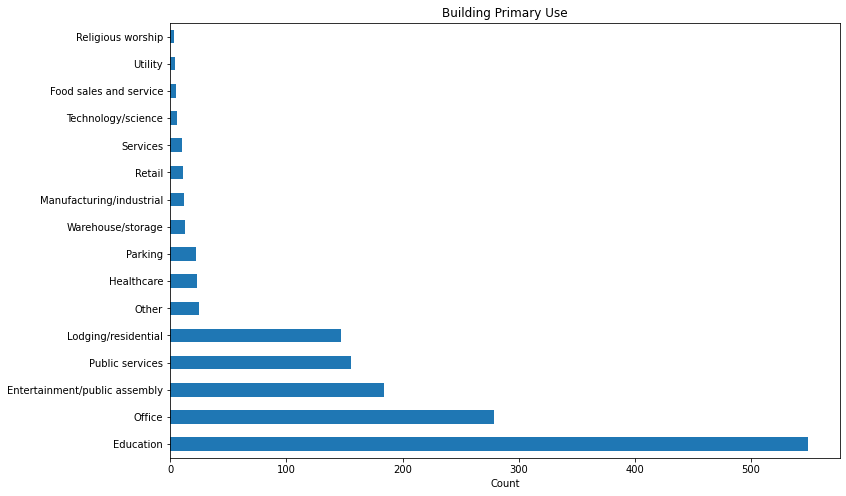

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
building_metadata['primary_use'].value_counts().plot(kind='barh', ax=ax)
ax.set_title('Building Primary Use')
ax.set_xlabel('Count')

#### 1.6.1.2 Site ID<a id='1.6.1.2_Site_ID'></a>

In [53]:
#select unique values
#building_metadata['site_id'].value_counts()
#calculate the percentage of each type out of all buildings in this dataset
#100*building_metadata['site_id'].value_counts()/len(building_metadata)
#Put the counts and percentages in the same df
site_id_df=pd.concat([building_metadata['site_id'].value_counts(),
                           100*building_metadata['site_id'].value_counts()/len(building_metadata)],axis=1)
site_id_df.columns=['Count','%']
site_id_df.sort_values(by='Count',ascending=False)
site_id_df

,Count,%
3,274,18.909593
13,154,10.628019
2,135,9.316770
9,124,8.557626
15,124,8.557626
0,105,7.246377
14,102,7.039337
4,91,6.280193
5,89,6.142167
8,70,4.830918


Sites 3 and 13 have the greatest percentages of the buildings.

What will be interesting to think about in the future are more details about the site ID. Its weather? Distribution of types of buildings? The energy use?

Text(0.5, 0, 'Count')

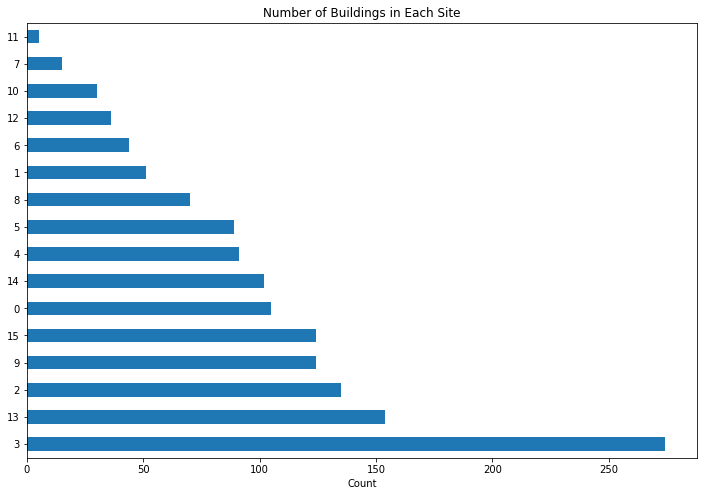

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
building_metadata['site_id'].value_counts().plot(kind='barh', ax=ax)
ax.set_title('Number of Buildings in Each Site')
ax.set_xlabel('Count')

#### 1.6.1.3 Meters<a id='1.6.1.3_Meters'></a>

How many of each meter does each type of building have? This is interesting to answer because the buildings can be different in the kind of energy that they consume

To answer this question, I have to merge the building_metadata and the meter_data

In [92]:
building_meter_data=meter_data.merge(building_metadata,on='building_id')
building_meter_data.head()
#len(building_meter_data)==len(meter_data)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN
1,0,0,2016-01-01 01:00:00,0.0,0,Education,7432,2008.0,NaN
2,0,0,2016-01-01 02:00:00,0.0,0,Education,7432,2008.0,NaN
3,0,0,2016-01-01 03:00:00,0.0,0,Education,7432,2008.0,NaN
4,0,0,2016-01-01 04:00:00,0.0,0,Education,7432,2008.0,NaN


After merging, here I replace the 0, 1, 2, and 3 values under meter with their corresponding meter types. From there, I create new columns from the strings under meter and give them 1/0 values, so that I can group by building type and get the percentage of each meter type for all meter readings. I also merge to this dataset the distribution by counts and percentage of building type, so I can sort the final dataset by primary_use %.

In [93]:
building_meter_data['meter'] = building_meter_data['meter'].map({0:'electricity', 1:'chilled_water',2:'steam',3:'hot_water'}) 
dummy_meter = pd.get_dummies(building_meter_data['meter'], prefix='meter')
building_meter_data = pd.merge(
    left=building_meter_data,
    right=dummy_meter,
    left_index=True,
    right_index=True,
)
building_meter_data.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,meter_chilled_water,meter_electricity,meter_hot_water,meter_steam
0,0,electricity,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,0,1,0,0
1,0,electricity,2016-01-01 01:00:00,0.0,0,Education,7432,2008.0,NaN,0,1,0,0
2,0,electricity,2016-01-01 02:00:00,0.0,0,Education,7432,2008.0,NaN,0,1,0,0
3,0,electricity,2016-01-01 03:00:00,0.0,0,Education,7432,2008.0,NaN,0,1,0,0
4,0,electricity,2016-01-01 04:00:00,0.0,0,Education,7432,2008.0,NaN,0,1,0,0


In [94]:
primary_use_meters=building_meter_data.groupby('primary_use')[['meter_chilled_water','meter_electricity','meter_hot_water','meter_steam']].mean()*100
primary_use_meters=primary_use_meters.merge(primary_use_df,on='primary_use')
primary_use_meters=primary_use_meters.sort_values(by='%',ascending=False,ignore_index=True)
primary_use_meters.head()

,primary_use,meter_chilled_water,meter_electricity,meter_hot_water,meter_steam,Count,%
0,Education,22.327158,56.300946,7.453355,13.918541,549,37.888199
1,Office,25.418284,52.565972,6.591558,15.424186,279,19.254658
2,Entertainment/public assembly,16.409564,66.726286,6.145391,10.718759,184,12.698413
3,Public services,10.817548,79.385636,4.752271,5.044545,156,10.766046
4,Lodging/residential,21.330145,57.262139,4.465590,16.942126,147,10.144928


Text(0.5, 0, 'building type')

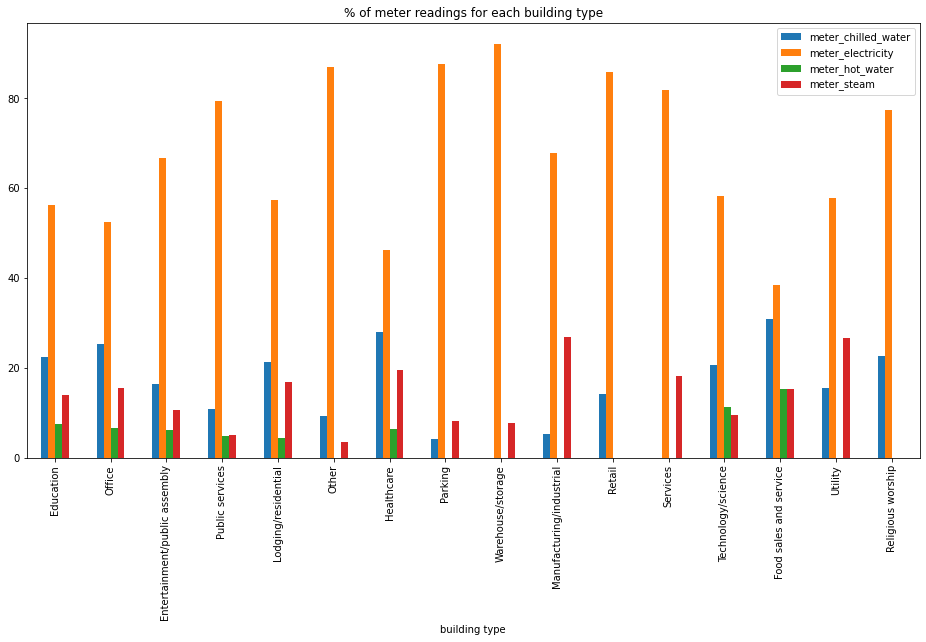

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
primary_use_meters.plot(x="primary_use", y=['meter_chilled_water','meter_electricity','meter_hot_water','meter_steam'], kind="bar", ax=ax)
ax.set_title('% of meter readings for each building type')
ax.set_xlabel('building type')

From the bargraph above we see that:
* all building types have mostly electricity meter readings. 
* Warehouse/Storage and Services don't have any chilled water meter readings. 
* 'Other', Parking, Warehouse/Storage, Manufacturing/industrial, Retail, Services, Utility, and Religious worship don't have any hot water meter readings 
* Retail and Religious worship don't have any steam meter readings. 

### 1.6.2 Numeric Features<a id='1.6.2_Numeric_Features'></a>

#### 1.6.2.1 Numeric Data Summary<a id='1.6.2.1_Numeric_Data_Summary'></a>

Before looking at the meter data, I will have to fix the electricity readings. According to the information in the kaggle competition, the unit for the electricity measurement is kBTU. So, to convert to kWh, I have to multiply by 0.2931. 

In [103]:
meter_data[meter_data['meter']==1].head()

,building_id,meter,timestamp,meter_reading
172,161,1,2016-01-01 00:00:00,0.000000
174,162,1,2016-01-01 00:00:00,0.000000
176,163,1,2016-01-01 00:00:00,1.340024
181,166,1,2016-01-01 00:00:00,61.517587
184,167,1,2016-01-01 00:00:00,0.000000


In [104]:
corrected_values=meter_data[meter_data['meter']==1]['meter_reading']*0.2931
corrected_meter_data=meter_data
corrected_meter_data.loc[corrected_meter_data['meter']==1,'meter_reading']=corrected_values
corrected_meter_data[corrected_meter_data['meter']==1]['meter_reading'].head()

172     0.000000
174     0.000000
176     0.392761
181    18.030805
184     0.000000
Name: meter_reading, dtype: float64

In [105]:
corrected_meter_data.describe().T

,count,mean,std,min,25%,50%,75%,max
building_id,20216100.0,799.278000,426.913309,0.0,393.000000,895.0000,1179.0,1448.0
meter,20216100.0,0.662441,0.930992,0.0,0.000000,0.0000,1.0,3.0
meter_reading,20216100.0,1997.343434,153194.199918,0.0,10.519473,50.8801,176.9,21904700.0


what is interesting to get an idea of is:
 * How many meter recordings are there for each building? In other words, do we have enough meter readings for each building?
 * How much data do we have for each type of meter for each building?
 * We could even go further and see if we have enough data for each type of building (e.g., education, office, etc)
     * In the case that we don't have enough data, we will have to assess if this data is worth keeping
     * I've answered some of this to some degree above
 * What are the mean, std, min, etc. for each type of meter? How much do they differ?
     
* To check whether the meter reading values make sense, I looked up from [EIA the electricity consumption totals for buildings](https://www.eia.gov/consumption/commercial/data/2012/c&e/cfm/pba4.php). According to the chart, a building consumes 14.6 kWh/sqft of electricity a year. This number corresponds to 362 kWh per hour for a 200,000 sqft building. While this value is larger than what the data contains, it is about the same order of magnitude. 

In [106]:
building_metadata.describe().T

,count,mean,std,min,25%,50%,75%,max
site_id,1449.0,6.952381,5.003432,0.0,3.0,5.0,13.0,15.0
building_id,1449.0,724.000000,418.434583,0.0,362.0,724.0,1086.0,1448.0
square_feet,1449.0,92111.776398,110769.950997,283.0,23012.0,57673.0,115676.0,875000.0
year_built,675.0,1967.957037,31.054030,1900.0,1949.0,1970.0,1995.0,2017.0
floor_count,355.0,3.740845,3.333683,1.0,1.0,3.0,5.0,26.0


In [107]:
weather_data.describe().T

,count,mean,std,min,25%,50%,75%,max
site_id,139773.0,7.478977,4.604744,0.0,3.0,7.0,11.0,15.0
air_temperature,139718.0,14.418106,10.626595,-28.9,7.2,15.0,22.2,47.2
cloud_coverage,70600.0,2.149306,2.599150,0.0,0.0,2.0,4.0,9.0
dew_temperature,139660.0,7.350158,9.790235,-35.0,0.6,8.3,14.4,26.1
precip_depth_1_hr,89484.0,0.983047,8.463678,-1.0,0.0,0.0,0.0,343.0
sea_level_pressure,129155.0,1016.158038,7.629684,968.2,1011.8,1016.4,1020.8,1045.5
wind_direction,133505.0,180.526632,111.523629,0.0,80.0,190.0,280.0,360.0
wind_speed,139469.0,3.560527,2.335874,0.0,2.1,3.1,5.0,19.0


Weather data was collected from a meteorological station as close as possible to the site.
* site_id
* air_temperature - Degrees Celsius
* [cloud_coverage](https://polarpedia.eu/en/okta-scale/#:~:text=1%20okta%20represents%20a%20cloud,fog%20or%20other%20meteorological%20phenomena.) - Portion of the sky covered in clouds, in oktas
* [dew_temperature](https://www.weather.gov/arx/why_dewpoint_vs_humidity) - Degrees Celsius
* [precip_depth_1_hr](https://water.usgs.gov/edu/activity-howmuchrain-metric.html) - Millimeters
* [sea_level_pressure](https://en.wikipedia.org/wiki/Atmospheric_pressure#:~:text=Average%20sea%2Dlevel%20pressure%20is,29.921%20inHg%3B%20760.00%20mmHg) - Millibar/hectopascals
* wind_direction - Compass direction (0-360)
* [wind_speed](http://gyre.umeoce.maine.edu/data/gomoos/buoy/php/variable_description.php?variable=wind_2_speed) - Meters per second

Things to keep in mind for data cleaning:

* Here we observe a precipitation depth of -1 mm. Is this something that makes sense? Should this be converted to 0 mm? How many of the values come out as negative and may have to be changed to 0 or null?

* According to USGS, a rainfall greater than 50 mm depth is a violent shower. The max in this dataset is 343 mm. Is this plausible or too high? Could this be a rare event? It looks like this is an outlier. The mean is 0.98 and the median is 0.0

* Average sea level pressure is 1013.25 mbar. This is close to the average in this dataset.



#### 1.6.2.2 Numeric Data Distribution<a id='1.6.2.2_Numeric_Data_Distribution'></a>

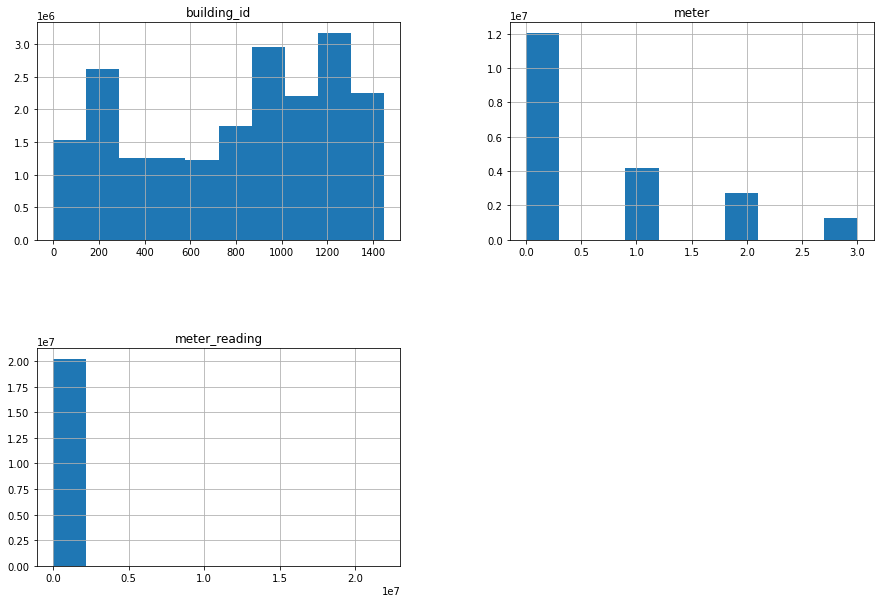

In [108]:
corrected_meter_data.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

* there are a lot more readings from the meter 0, which is for electricity
* Not sure how relevant this is... but there are more buildings of those with IDs 700 to 1400... maybe these are more of the education type?
* The meter_reading histogram and the description table with simple statistics clearly shows there is an outlier. The max for the meter reading is 21904700.0!!!
* I need to investigate this issue with the meter further. 
    * what is a meter reading that makes sense?
    * What buildings are recording that crazy value for the meter readings? what type of meters are these?
    * To get started, I will get the number of meters out of all of the data reading greater than:
        * 2e7
        * 1e7
        * 1e6
        * 1e5
        * 1e4
        * 1e3
        * 1e2
        * 1

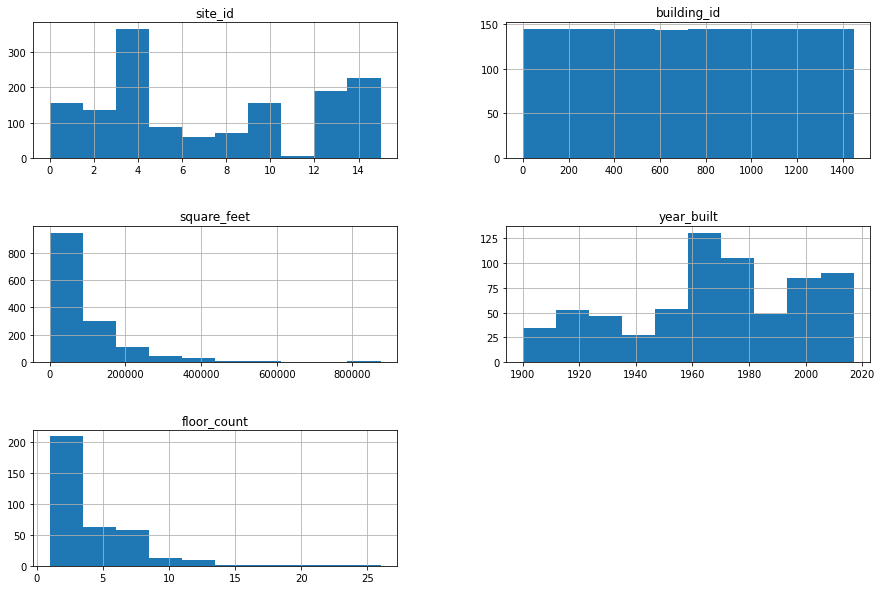

In [109]:
building_metadata.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

The building characteristics dataset looks okay to me. 

* There are some outliers with bigger buildings. It may be interesting to grab more details about these buildings. What type of buildings are these? Do they consume a lot of energy?
* Most of the buildings were built after 1960. How related is energy consumption to the year that it was built? It should be noted that we are missing half of the year_built values. 
* Also, it should be noted that we are also missing 75% of the floor_count values.
* Another thing that could be checked as I go through this project is whether floor count and square_feet correlate. If so, floor_count could be removed since it is missing a lot of the data and square_feet could be enough to capture the influence of building size on energy consumption.

<AxesSubplot:xlabel='square_feet', ylabel='floor_count'>

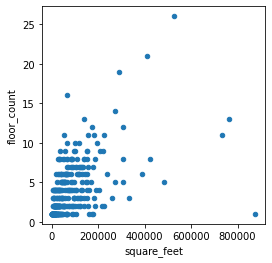

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
building_metadata.plot(x="square_feet", y='floor_count', kind="scatter", ax=ax)

They don't... 

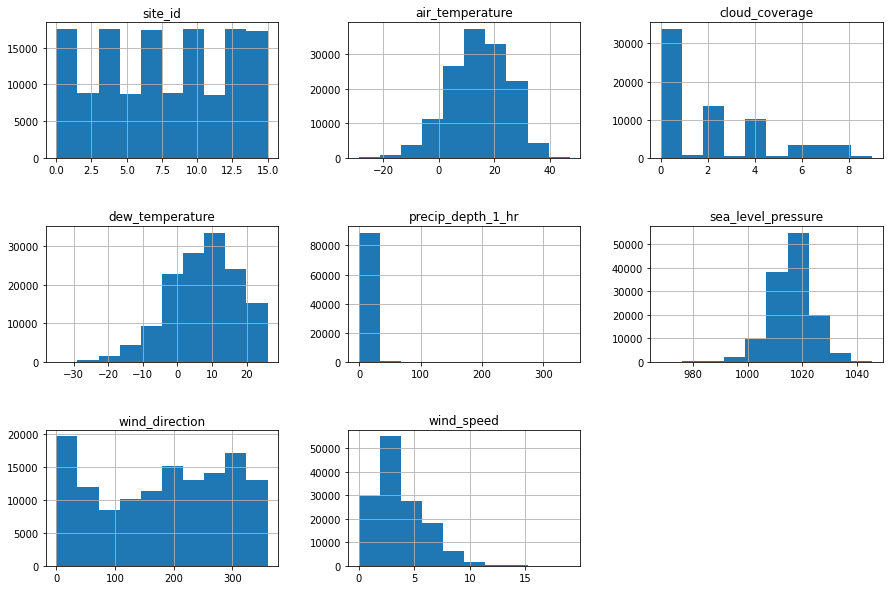

In [111]:
weather_data.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

I need to remember this data is collected for each timestamp in all of 2016 for each site_id

### 1.6.3 Identifying Potential Outliers<a id='1.6.3_Identifying_Potential_Outliers'></a>

In section 1.6.2, I identified features that could potentially contain outliers. These features are:
   * meter_reading
   * precip_depth_1_hr
    
Other features that are skewed and worth looking at are:
   * square_feet
   * floor_count

While cloud_coverage and wind_speed are also skewed, after checking online what appropriate values for these features are, I realized they are okay. For these in particular, what should be kept in mind is whether floor_count column should be removed since it is missing 75% of the data.

#### 1.6.3.1 Potential Outliers in meter_reading<a id='1.6.3.1_Potential_Outliers_in_meter_reading'></a>

<AxesSubplot:>

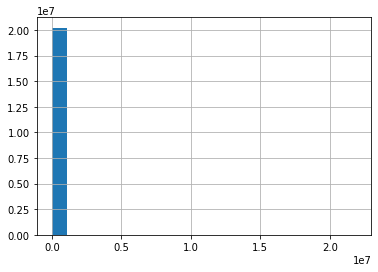

In [112]:
corrected_meter_data['meter_reading'].hist(bins=20)

* The meter_reading histogram and the description table with simple statistics clearly shows there is an outlier. The max for the meter reading is 21904700.0!!!
    * what is a meter reading that makes sense? - After checking the EIA website, no more than hundreds magnitude
    * What buildings are recording that crazy value for the meter readings? what type of meters are these?
    * To get started, I will get the number of meters out of all of the data reading greater than:
        * 2e7
        * 1e7
        * 1e6
        * 1e5
        * 1e4
        * 1e3
        * 1e2
        * 1

In [113]:
thresholds=[1,1e2,5e2,1e3,1e4,1e5,1e6,1e7,2e7]
thresholds_df=pd.DataFrame(columns=['Reading Threshold (kWh)','Count','% of All Readings Greater than Threshold'])
for threshold in thresholds:
    count=len(corrected_meter_data[corrected_meter_data['meter_reading'] > threshold]['meter_reading'])
    percentage=100*(len(corrected_meter_data[corrected_meter_data['meter_reading'] > threshold]['meter_reading'])
                    /len(corrected_meter_data))
    thresholds_df=thresholds_df.append({'Reading Threshold (kWh)':threshold,
                                        'Count':count,
                                        '% of All Readings Greater than Threshold':percentage},
                                       ignore_index=True);
thresholds_df

C:\Users\baro284\AppData\Local\Temp\ipykernel_18156\1460016286.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  thresholds_df=thresholds_df.append({'Reading Threshold (kWh)':threshold,
C:\Users\baro284\AppData\Local\Temp\ipykernel_18156\1460016286.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  thresholds_df=thresholds_df.append({'Reading Threshold (kWh)':threshold,
C:\Users\baro284\AppData\Local\Temp\ipykernel_18156\1460016286.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  thresholds_df=thresholds_df.append({'Reading Threshold (kWh)':threshold,
C:\Users\baro284\AppData\Local\Temp\ipykernel_18156\1460016286.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

,Reading Threshold (kWh),Count,% of All Readings Greater than Threshold
0,1.0,17695832.0,87.533362
1,100.0,7315160.0,36.184823
2,500.0,2164360.0,10.70612
3,1000.0,1096003.0,5.421436
4,10000.0,83569.0,0.413378
5,100000.0,4331.0,0.021424
6,1000000.0,3067.0,0.015171
7,10000000.0,1498.0,0.00741
8,20000000.0,83.0,0.000411


* Meter readings greater than 1e4 may be worth removing. They only consist of 0.4% of the data. 
* Meter readings greater than 1e3 and less than 1e4 are 5.6% of the data. It may be worth revising this data before deciding to remove it.

Let's look at the data distribution and statistics when values <b>greater than 1e4</b> are overlooked.

In [114]:
corrected_meter_data[corrected_meter_data['meter_reading']<1e4].describe().T.loc['meter_reading']

count    2.013247e+07
mean     2.361385e+02
std      6.591976e+02
min      0.000000e+00
25%      1.040000e+01
50%      5.027550e+01
75%      1.740000e+02
max      9.999600e+03
Name: meter_reading, dtype: float64

<AxesSubplot:>

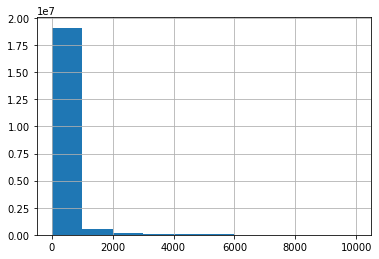

In [115]:
corrected_meter_data[corrected_meter_data['meter_reading']<1e4]['meter_reading'].hist()

Let's look at the data distribution and statistics when values <b>greater than 1e3</b> are overlooked.

In [116]:
corrected_meter_data[corrected_meter_data['meter_reading']<1e3].describe().T.loc['meter_reading']

count    1.911907e+07
mean     1.184254e+02
std      1.793657e+02
min      0.000000e+00
25%      9.090915e+00
50%      4.420000e+01
75%      1.425000e+02
max      9.999980e+02
Name: meter_reading, dtype: float64

<AxesSubplot:>

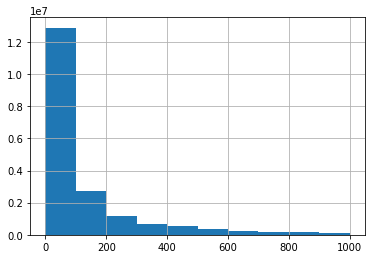

In [117]:
corrected_meter_data[corrected_meter_data['meter_reading']<1e3]['meter_reading'].hist()

The data is quite skewed. The next interesting thing to do is look at the meters and types of buildings (and size) reporting more that 200 kWh. Other things to look at are time of day, or day of the week, and weather conditions like air temperature.


#### 1.6.3.2 Potential Outliers in precip_depth_1_hr<a id='1.6.3.2_Potential_Outliers_in_precip_depth_1_hr'></a>

<AxesSubplot:>

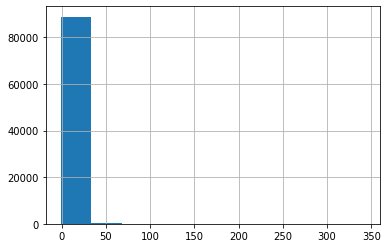

In [118]:
weather_data['precip_depth_1_hr'].hist()

Some of the data have a value of -1. These could be interpretted as null values. What percentage of the data have a value of -1, in addition to the null values? As a reminder, about 36% percent of the entries for this feature are null values.

In [120]:
weather_data_missing.loc['precip_depth_1_hr']['%']+
100*len(weather_data[weather_data['precip_depth_1_hr']==-1])/len(weather_data)

40.114328232205075

40% of the precip_depth_1_hr are missing. 

what percentage have a value of 0.0, which would correspond to no precipitation?

In [122]:
100*len(weather_data[weather_data['precip_depth_1_hr']==0.0])/len(weather_data)

55.74037904316284

In addition to 40% of the data missing, 55.7 % have a value of 0.0

In [131]:
100*len(weather_data[weather_data['precip_depth_1_hr']>0.0])/len(weather_data)

4.145292724632082

4% of the data have a precipitation greater than 0.0.

In [125]:
100*len(weather_data[weather_data['precip_depth_1_hr']>=50])/len(weather_data)

0.27401572549777137

according to USGS (U.S. Geological Service): "Violent shower: Greater than 50 mm per hour.""

In [132]:
extreme_precip=weather_data[weather_data['precip_depth_1_hr']>=50]

How much did it rain in each site_id?

In [133]:
extreme_precip.groupby('site_id')['precip_depth_1_hr'].sum().sort_values()

site_id
10     385.0
2      531.0
4      625.0
3     1378.0
14    2264.0
7     2453.0
11    2453.0
6     2595.0
15    2746.0
9     3428.0
13    3910.0
0     8245.0
8     8245.0
Name: precip_depth_1_hr, dtype: float64

It rained the most in site_id's 0 and 8. It did not rain at all in site_id's 1, 5, and 12.

It will be interesting to look at where and when these violent showers occurred. These can be sorted by month...

In [142]:
extreme_precip.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
353,0,2016-01-15 17:00:00,17.8,NaN,16.7,165.0,1008.5,240.0,5.1
671,0,2016-01-28 23:00:00,17.8,NaN,16.7,112.0,1007.7,320.0,5.1
2016,0,2016-03-25 00:00:00,21.1,8.0,20.0,122.0,1015.8,0.0,0.0
2017,0,2016-03-25 01:00:00,18.9,NaN,17.8,343.0,1015.7,50.0,1.5
2019,0,2016-03-25 03:00:00,20.0,NaN,18.9,130.0,1016.5,170.0,4.1


In [159]:
extreme_precip['timestamp']=pd.to_datetime(extreme_precip['timestamp'])
extreme_precip['Month'] = pd.DatetimeIndex(extreme_precip['timestamp']).month
#extreme_precip['month'] = extreme_precip['timestamp'].dt.strftime("%Y-%m-%d %H:%M:%S").month

C:\Users\baro284\AppData\Local\Temp\ipykernel_20372\3185664040.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extreme_precip['timestamp']=pd.to_datetime(extreme_precip['timestamp'])
C:\Users\baro284\AppData\Local\Temp\ipykernel_20372\3185664040.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extreme_precip['Month'] = pd.DatetimeIndex(extreme_precip['timestamp']).month


In [160]:
extreme_precip.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,Month
353,0,2016-01-15 17:00:00,17.8,NaN,16.7,165.0,1008.5,240.0,5.1,2016-01-15 17:00:00,1
671,0,2016-01-28 23:00:00,17.8,NaN,16.7,112.0,1007.7,320.0,5.1,2016-01-28 23:00:00,1
2016,0,2016-03-25 00:00:00,21.1,8.0,20.0,122.0,1015.8,0.0,0.0,2016-03-25 00:00:00,3
2017,0,2016-03-25 01:00:00,18.9,NaN,17.8,343.0,1015.7,50.0,1.5,2016-03-25 01:00:00,3
2019,0,2016-03-25 03:00:00,20.0,NaN,18.9,130.0,1016.5,170.0,4.1,2016-03-25 03:00:00,3


The next steps are to figure out what to do with precip and outliers of meter readings. remove? replace with mean? median? How do I assess this? I forget

For the greatly skewed data, replace with categorical values?

need to think about cloud_coverage and floor_count, which are missing 50% and 75% of the data, respectively.